IMPORT

In [1]:
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
import cv2
import dlib
import sys
sys.path.append('./SkinDetector')
import skin_detector
import datetime as dt

Load File

In [2]:
subject_name = '01-01'
dataset_path = 'PURE/'

img_frame_path = dataset_path + subject_name + '/01-01/'

png_list = glob(img_frame_path + '*.png')
png_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(f"First 10 frames: {png_list[:10]}")
print(f"Length: {len(png_list)}")

First 10 frames: ['PURE/01-01/01-01\\Image1392643993642815000.png', 'PURE/01-01/01-01\\Image1392643993676160000.png', 'PURE/01-01/01-01\\Image1392643993709504000.png', 'PURE/01-01/01-01\\Image1392643993742818000.png', 'PURE/01-01/01-01\\Image1392643993776162000.png', 'PURE/01-01/01-01\\Image1392643993809507000.png', 'PURE/01-01/01-01\\Image1392643993842821000.png', 'PURE/01-01/01-01\\Image1392643993876165000.png', 'PURE/01-01/01-01\\Image1392643993909509000.png', 'PURE/01-01/01-01\\Image1392643993942823000.png']
Length: 2026


Global Variabel

In [3]:
idx_frame_start = 0
idx_frame_end = len(png_list) - 1
fps = 30
n_segment = 6
left_expand_ratio = 0.25
top_expand_ratio = 0.25

f_cnt = 0
i_cnt = idx_frame_start

In [4]:
detector = dlib.get_frontal_face_detector()

In [5]:
face_left, face_top, face_right, face_bottom = 0,0,0,0
mask = None
n_skinpixels = 0

In [6]:
while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):

    frame = cv2.imread(png_list[i_cnt])
    h, w, _ = frame.shape

    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, WidthL {w}")

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if f_cnt == 0:
        rect = detector(gray_frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()  

        width = abs (right - left)
        height = abs (bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        face_top = int (top - (top_expand_ratio/2 * width ))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    if mask is None:
        mask = skin_detector.process(face)
        n_skinpixels = np.sum(mask)

    # print(f"Mask: \n {mask}")
    # print(f"Number of skinpixels: {n_skinpixels}")

    masked_face = cv2.bitwise_and(face, face, mask=mask)

    # frame_toshow= cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels

    if f_cnt ==0:
        mean_rgb = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb = np.vstack((mean_rgb,np.array([mean_r, mean_g, mean_b])))

    f_cnt += 1
    i_cnt += 1


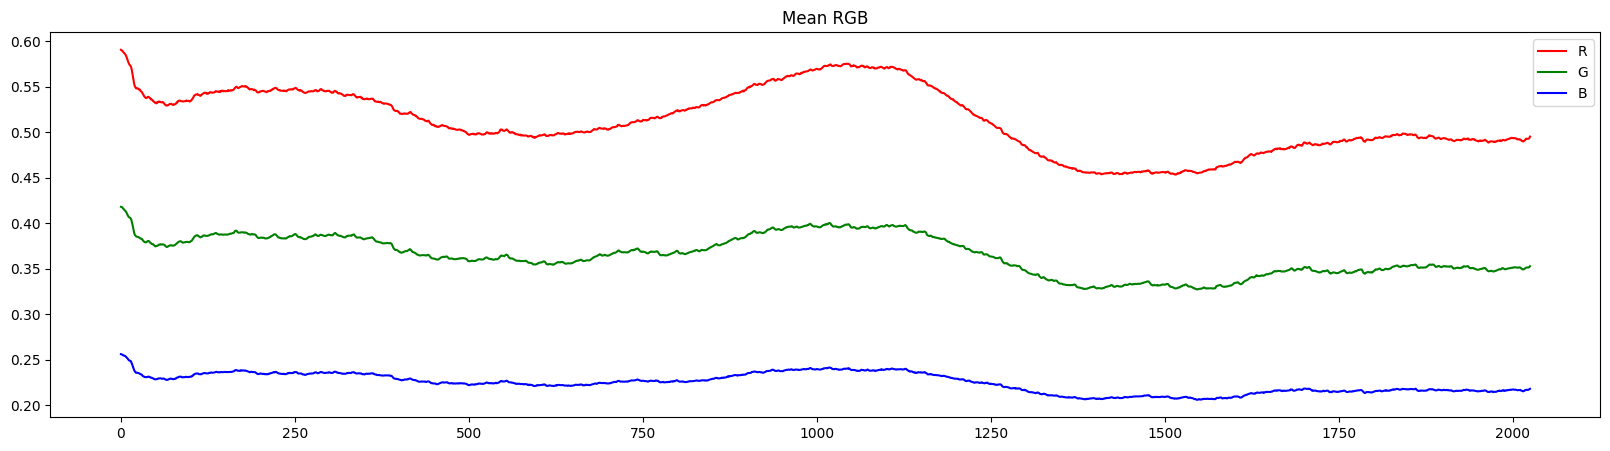

In [7]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb[:,0], label = 'R', color='red')
plt.plot(mean_rgb[:,1], label = 'G', color='green')
plt.plot(mean_rgb[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

POS

In [28]:
l = int(fps * 1.6)
print(f"Window length: {l}")
rPPG_signals = np.zeros(mean_rgb.shape[0])
print(f"rPPG_signals shape: {rPPG_signals.shape}")

Window length: 48
rPPG_signals shape: (2026,)


In [30]:
for t in range (0, mean_rgb.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb[t:t+l-1,:].T

    print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals[t:t+l-1] = rPPG_signals[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 47)
C shape: (3, 4

Shape of rPPG_signals: (2026,)


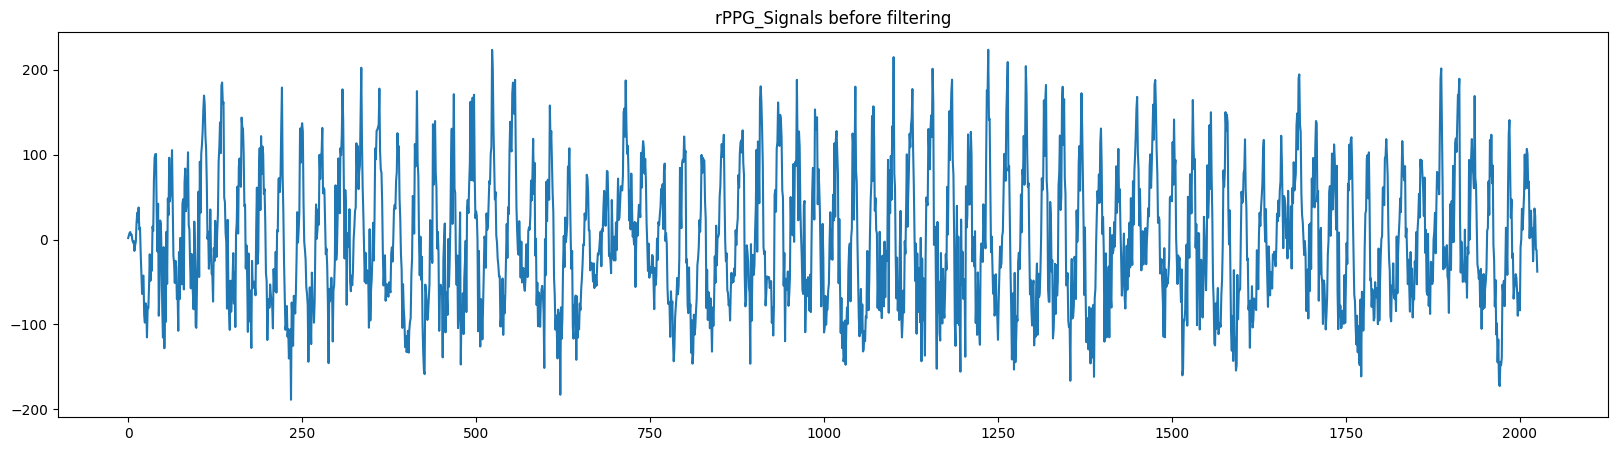

In [32]:
print(f"Shape of rPPG_signals: {rPPG_signals.shape}")
plt.figure(figsize=(20,5))
plt.plot(rPPG_signals)
plt.title(f"rPPG_Signals before filtering")
plt.show()

Shape of rPPG_signals: (2026,)
[ -8.48658005  -9.47262268 -10.05300714 ...  -4.25653992  -4.93205766
  -6.14780881]


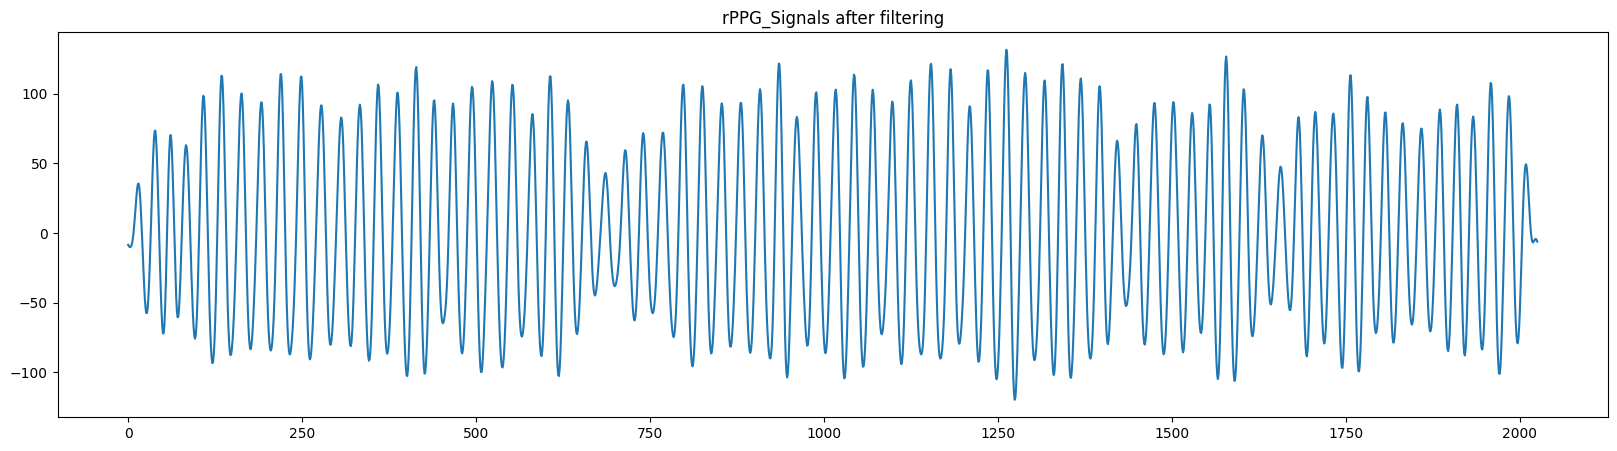

In [33]:
from scipy import signal

lowcut = 0.8
highcut = 2

b, a = signal.butter(2, [lowcut, highcut], btype='bandpass', fs=fps)
rPPG_filtered = signal.filtfilt(b, a, rPPG_signals)

print(f"Shape of rPPG_signals: {rPPG_filtered.shape}")
print(rPPG_filtered)
plt.figure(figsize=(20,5))
plt.plot(rPPG_filtered)
plt.title(f"rPPG_Signals after filtering")
plt.show()